# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import PIL
import os
from pathlib import Path
import sys

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D


import warnings
warnings.filterwarnings("ignore")

# 2. Dataset Acquisition & Analysis

## 2.1 Load Dataset

In [2]:
# Connect to google drive to upload dataset file

from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# Unzip dataset file

!unzip "/content/gdrive/My Drive/Alzheimer_MRI_Preprocessed_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/N

## 2.2 Dataset Information

In [4]:
# Classes Labels
ds_classes = os.listdir("Dataset/")
print("Class labels in Dataset:", ds_classes)

Class labels in Dataset: ['Mild_Demented', 'Non_Demented', 'Moderate_Demented', 'Very_Mild_Demented']


In [5]:
# Number of imagess in each class folder in dataset
data_dir = Path("Dataset/")
for label in ds_classes:
  print("Number of images in class '", str(label), "' is", len(os.listdir(os.path.join(data_dir, label))), "images")

Number of images in class ' Mild_Demented ' is 896 images
Number of images in class ' Non_Demented ' is 3200 images
Number of images in class ' Moderate_Demented ' is 64 images
Number of images in class ' Very_Mild_Demented ' is 2240 images


## 2.3 Dataset Visualization

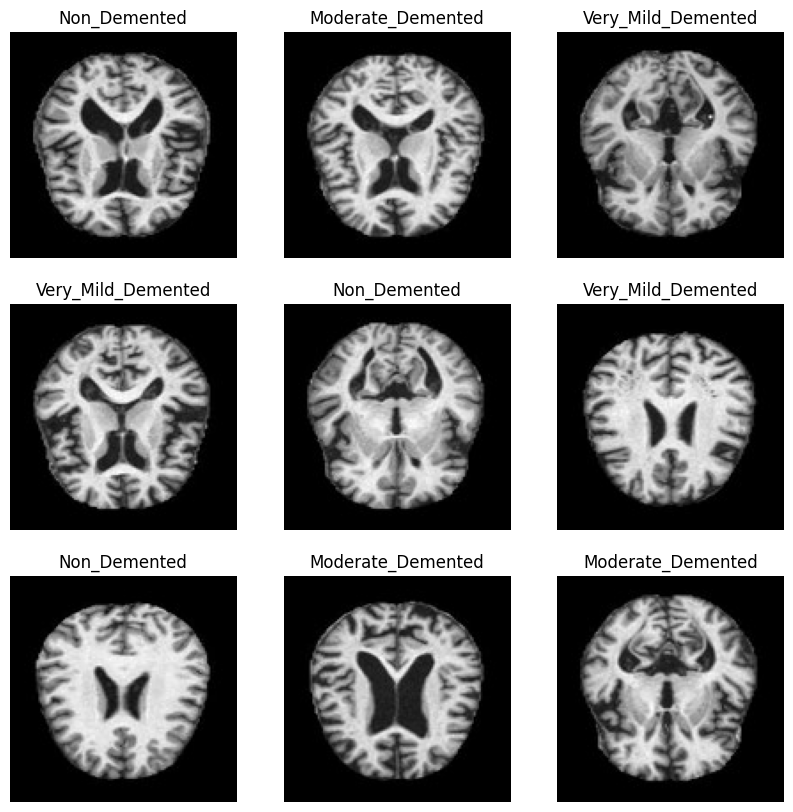

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    random_class = random.randint(0, 3)
    folder_path = 'Dataset/' + ds_classes[random_class] + '/'
    random_image_path = folder_path + (random.sample(os.listdir(folder_path), 1)[0])
    image = plt.imread(random_image_path)
    img_bw = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title(ds_classes[random_class])
    plt.imshow(img_bw)

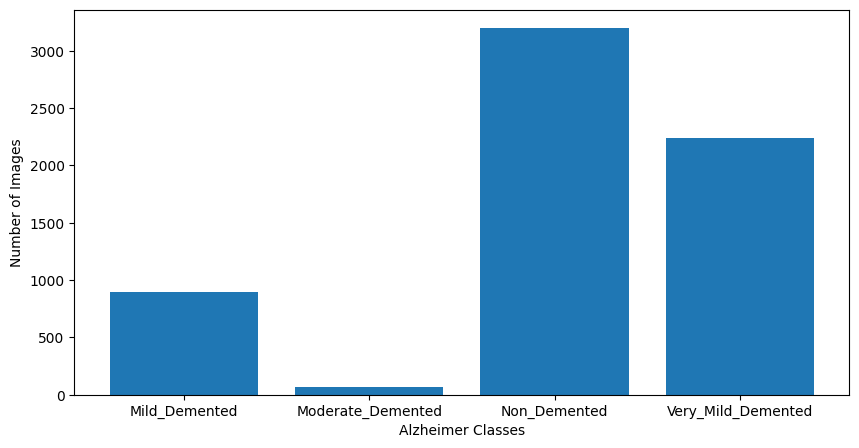

In [7]:
class_labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
class_size = [896,64,3200,2240]
plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_size)
plt.xlabel("Alzheimer Classes")
plt.ylabel("Number of Images")
plt.show()

# 3. Dataset Pre-Processing

## 3.1 Split Dataset

Split the dataset into train, validation and test datasets

In [8]:
# pip install split-folders directly to colab in order to use it
!pip install split-folders

In [9]:
import splitfolders

# Add the data directory, state the created split folder name and set the split ratio
splitfolders.ratio(data_dir, output="split", seed=1234, ratio=(0.8, 0.1, 0.1))

Copying files: 6400 files [00:01, 5023.62 files/s]


In [10]:
img_size = 128
batch_size = 32

In [11]:
# Create Train Dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    "split/train",
    seed=1234,
    shuffle = True,
    image_size = (img_size, img_size),
    batch_size=batch_size)

Found 5119 files belonging to 4 classes.


In [12]:
# Create Validation Dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    "split/val",
    seed=1234,
    shuffle = True,
    image_size=(img_size, img_size),
    batch_size=batch_size)

Found 639 files belonging to 4 classes.


In [13]:
# Create Test Dataset

test_ds = tf.keras.utils.image_dataset_from_directory(
    "split/test",
    seed=1234,
    shuffle = True,
    image_size=(img_size, img_size))

Found 642 files belonging to 4 classes.


In [14]:
class_names = train_ds.class_names
class_names

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [15]:
train_class_names = train_ds.class_names
print("Classes in training dataset",train_class_names)

Classes in training dataset ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [16]:
val_class_names = val_ds.class_names
print("Classes in validation dataset",val_class_names)

Classes in validation dataset ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [17]:
test_class_names = test_ds.class_names
print("Classes in test dataset", test_class_names)

Classes in test dataset ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


## 3.2 Visualization

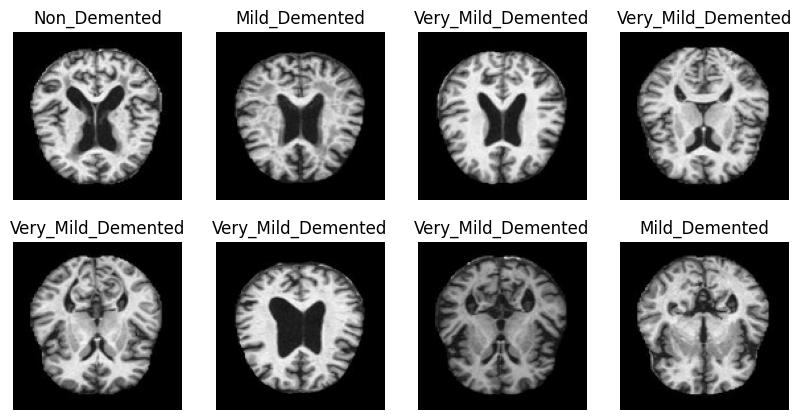

In [18]:
# Train Dataset

plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

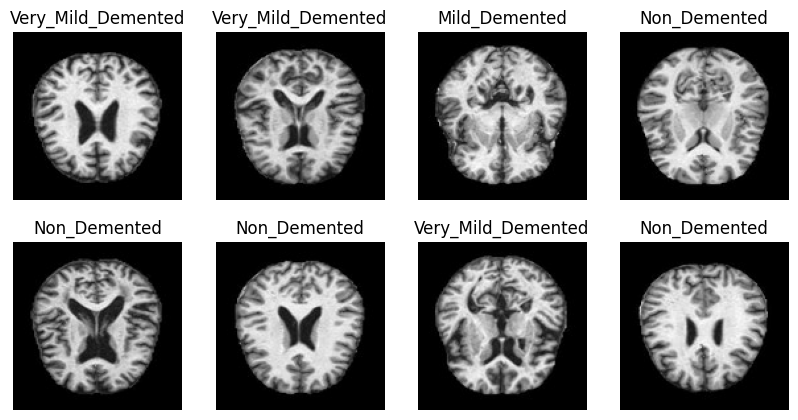

In [19]:
# Validation Dataset

plt.figure(figsize=(10, 5))
for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

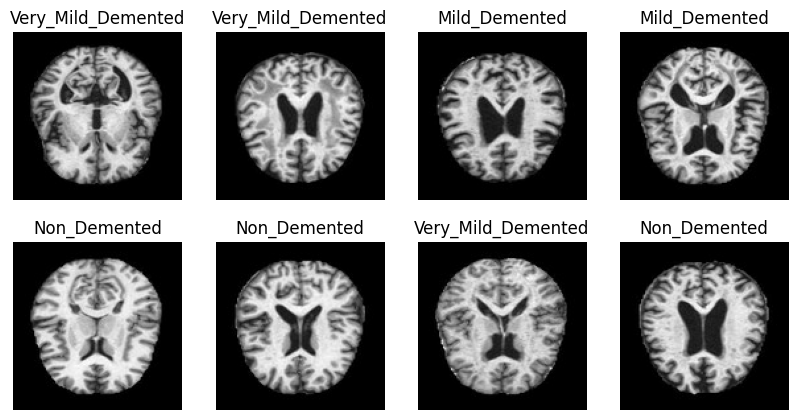

In [20]:
# Test Dataset

plt.figure(figsize=(10, 5))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
for images, labels in train_ds:
    print(images.shape)
    print(labels.shape)
    break

(32, 128, 128, 3)
(32,)


In [22]:
for images, labels in val_ds:
    print(images.shape)
    print(labels.shape)
    break

(32, 128, 128, 3)
(32,)


In [23]:
for images, labels in test_ds:
    print(images.shape)
    print(labels.shape)
    break

(32, 128, 128, 3)
(32,)


## 3.4 Dataset Configuration

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#4. CNN Model

## 4.1 Create Sequential Model

In [25]:
model_1 = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),

    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,484 (4.09 MB)

 Trainable params: 1,072,484 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Fit & Train Model

In [26]:
model_1.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])
history = model_1.fit(train_ds, validation_data = val_ds, epochs=20)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.4858 - loss: 1.0483 - val_accuracy: 0.5947 - val_loss: 0.8922
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6039 - loss: 0.8520 - val_accuracy: 0.6072 - val_loss: 0.8230
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7124 - loss: 0.6736 - val_accuracy: 0.7668 - val_loss: 0.5650
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8178 - loss: 0.4329 - val_accuracy: 0.8419 - val_loss: 0.3892
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8842 - loss: 0.2740 - val_accuracy: 0.9218 - val_loss: 0.2224
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9373 - loss: 0.1701 - val_accuracy: 0.9374 - val_loss: 0.1883
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9871 - loss: 0.0567 - val_accuracy: 0.9468 - val_loss: 0.1293
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9835 - loss: 0.0497 - val_accuracy

## 4.3 Plot Model Accuracy & Loss


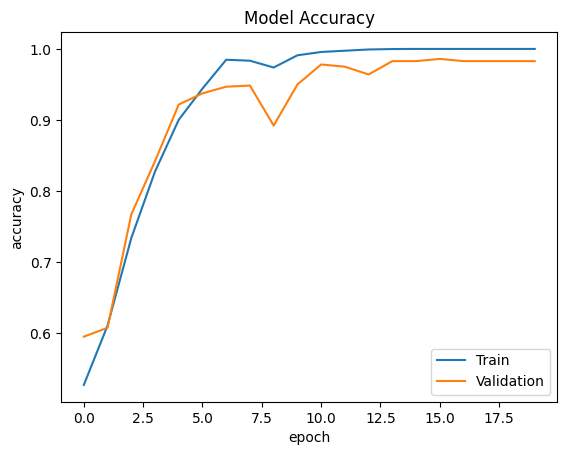

In [27]:
# Model Train & Validation Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training and Validation Accuracy")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

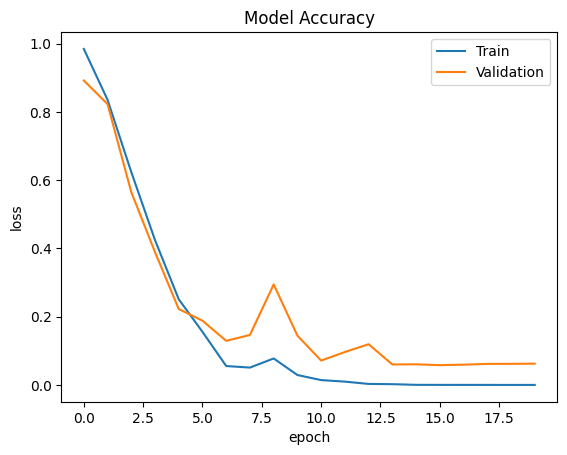

In [28]:
# Model Train & Validation Accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training and Validation Loss")
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## 4.4 Model Evaluation

In [29]:
train_evaluate = model_1.evaluate(train_ds)
print("Training Accuracy: {:.2f}%".format(train_evaluate[1]*100))
print("Training Loss: {:.2f}%".format(train_evaluate[0]*100))

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7788e-05
Training Accuracy: 100.00%
Training Loss: 0.01%


In [30]:
val_evaluate = model_1.evaluate(val_ds)
print("Validation Accuracy: {:.2f}%".format(val_evaluate[1]*100))
print("Validation Loss: {:.2f}%".format(val_evaluate[0]*100))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.0797
Validation Accuracy: 98.28%
Validation Loss: 6.24%


## 4.5 Evaluation on Test Data

Accuracy: 98.44%
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       1.00      0.96      0.98        91
 Moderate_Demented       1.00      0.86      0.92         7
      Non_Demented       0.99      0.98      0.99       320
Very_Mild_Demented       0.97      1.00      0.98       224

          accuracy                           0.98       642
         macro avg       0.99      0.95      0.97       642
      weighted avg       0.98      0.98      0.98       642



Text(0.5, 23.38159722222222, 'Predicted label')

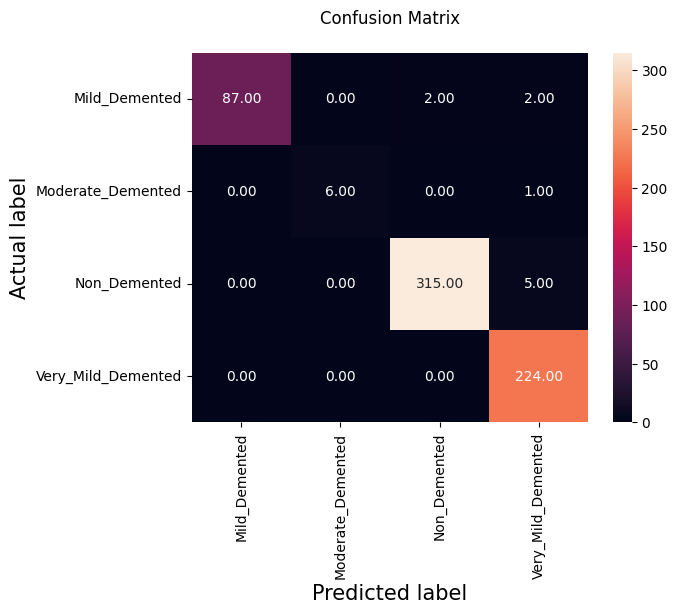

In [31]:
actual = []
predicted= []

for image, label in test_ds.as_numpy_iterator():
    predictions = model_1.predict(image, verbose=0)
    pred = np.argmax(predictions, axis=1)
    predicted.extend(pred)
    actual.extend(label)

actual = np.array(actual)
predicted = np.array(predicted)

print("Accuracy: {:.2f}%".format(metrics.accuracy_score(actual, predicted)*100))
print("Classification Report:\n", metrics.classification_report(actual, predicted, target_names=class_names))
cm = metrics.confusion_matrix(actual, predicted)
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = class_names , yticklabels = class_names)
plt.title('Confusion Matrix\n');
plt.ylabel('Actual label',fontsize=15)
plt.xlabel('Predicted label',fontsize=15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


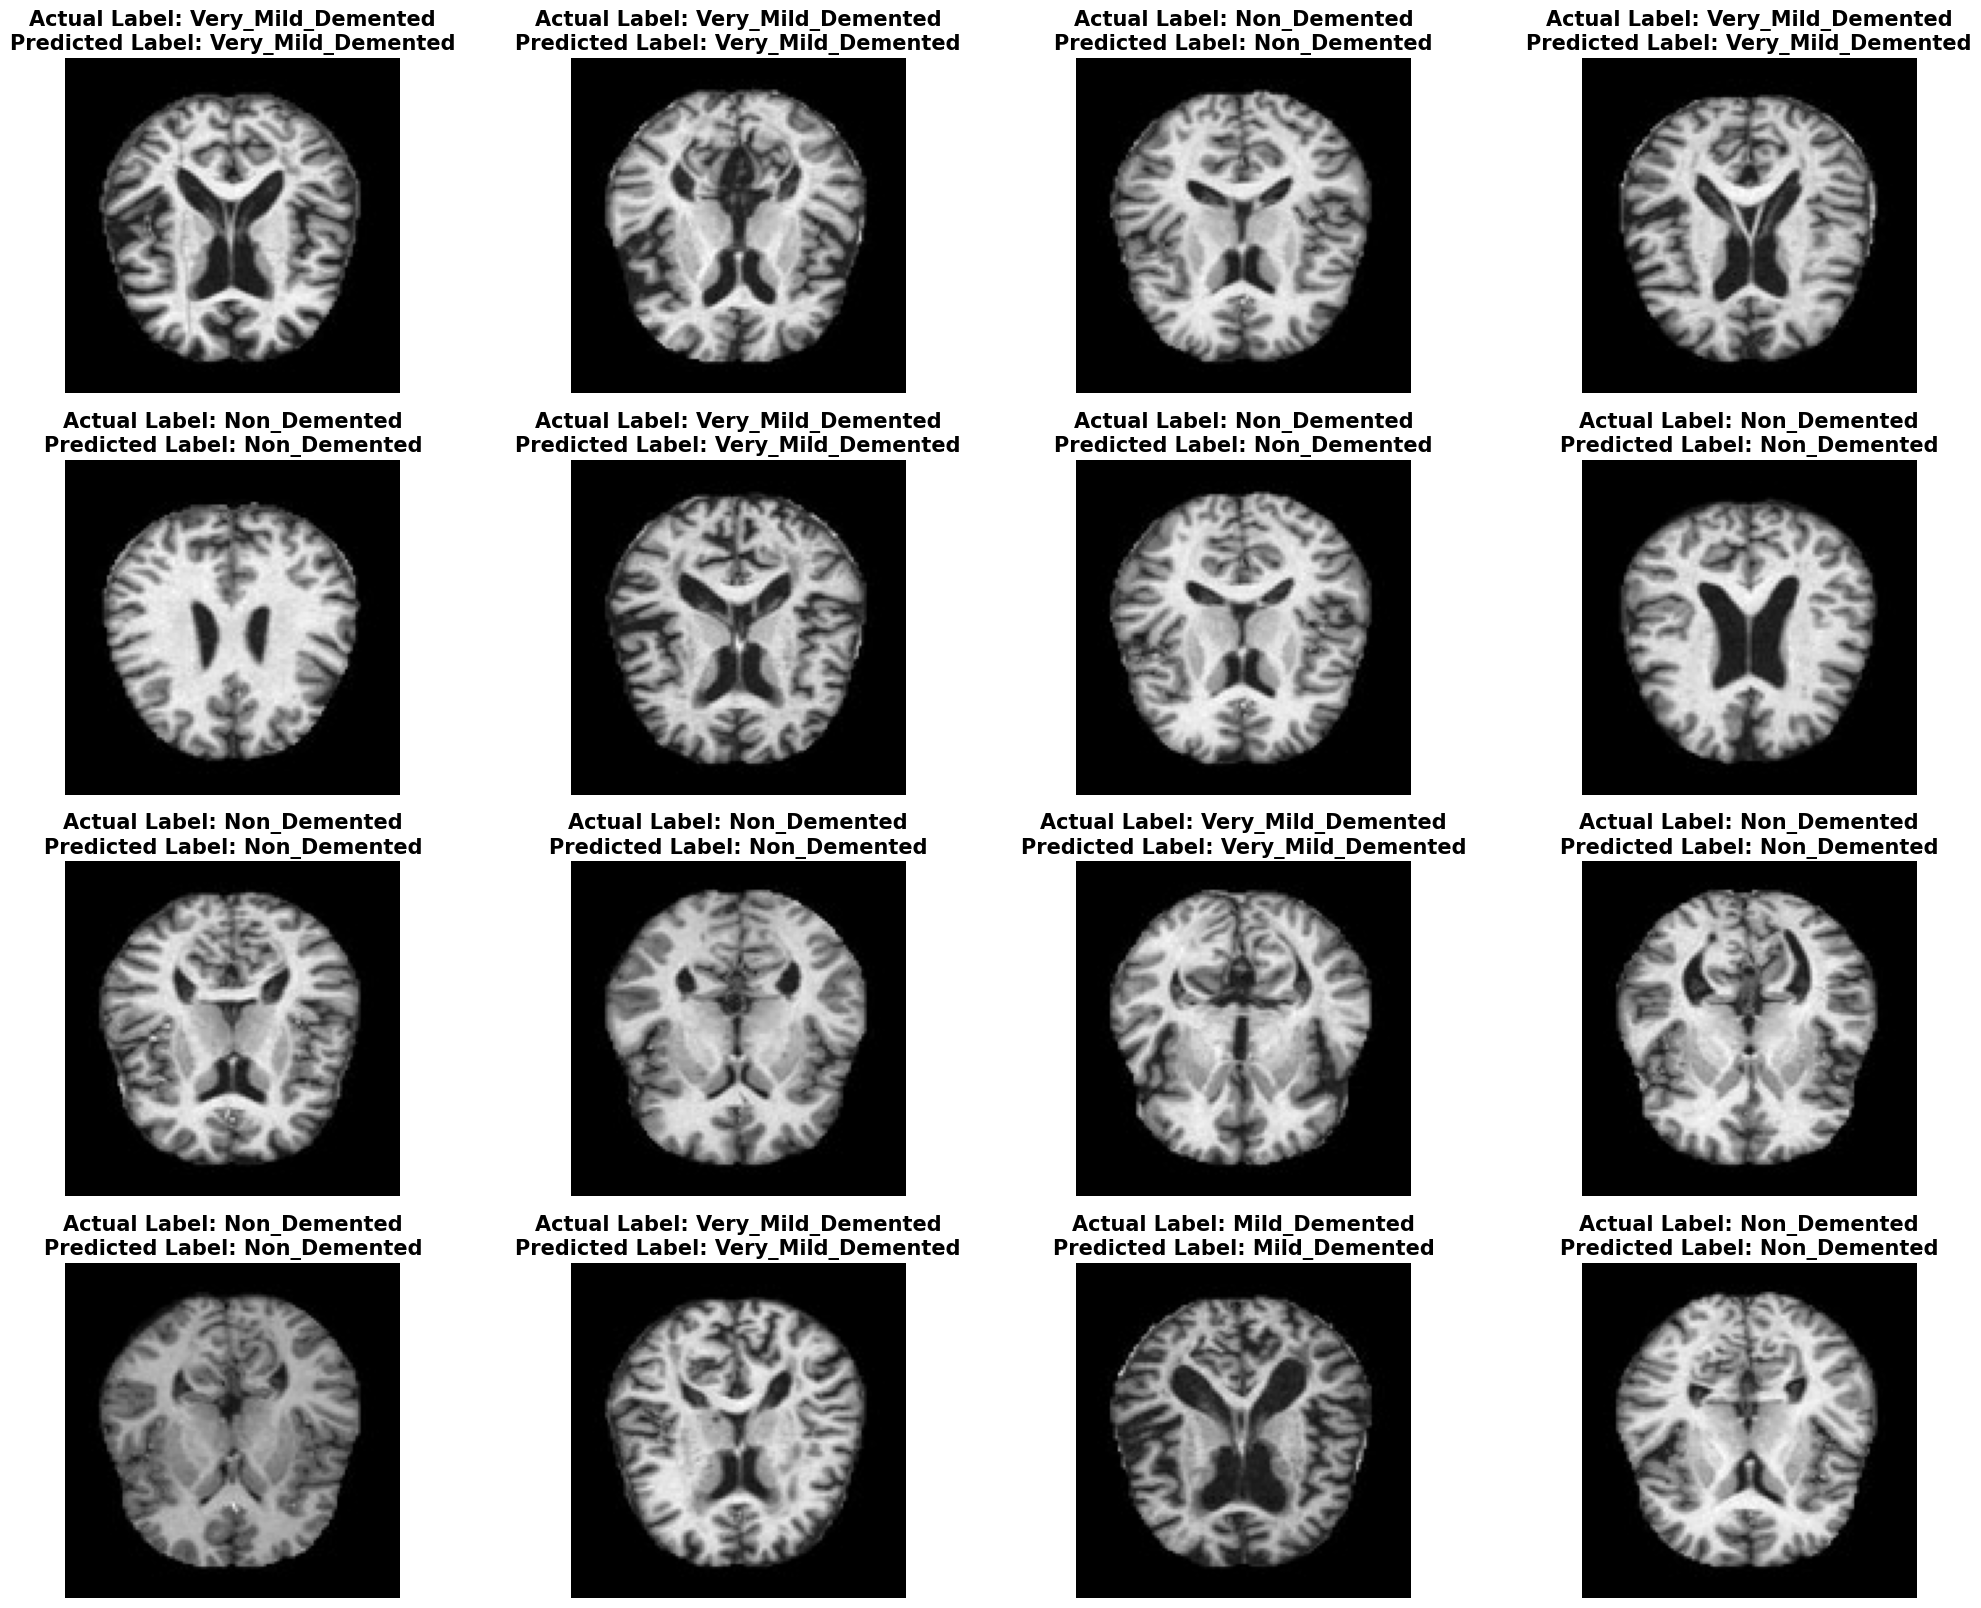

In [32]:
plt.figure(figsize=(25, 20))
for image, label in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model_1.predict(img))
        plt.axis('off')
        plt.title("Actual Label: " + class_names[label[i]] + "\nPredicted Label: " + class_names[predicted_class], fontsize=15, fontweight = 'bold', style='normal', loc='center')
        plt.imshow(image[i].numpy().astype("uint8"))

#5. CNN Model With Resampling

## 5.1 Class Imbalance

In [33]:
# Prepare Train Dataset For resampling
train_images = []
train_labels = []
for images, labels in train_ds:
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE() # Initialze SMOTE

# Fit SMOTE initialzer on data to resample it
train_images_res, train_labels_res = smote.fit_resample(train_images.reshape(-1, img_size * img_size * 3), train_labels)

In [35]:
from collections import Counter

before_samples = Counter(train_labels)
print("Number of samples before SMOTE resampling", before_samples)

after_samples = Counter(train_labels_res)
print("Number of samples after SMOTE resampling", after_samples )

Number of samples before SMOTE resampling Counter({2: 2560, 3: 1792, 0: 716, 1: 51})
Number of samples after SMOTE resampling Counter({2: 2560, 1: 2560, 3: 2560, 0: 2560})


In [36]:
# Reshape data to be easily input into the models turn it into a dataset format with images and labels
train_images_res = train_images_res.reshape(-1, img_size, img_size, 3)
train_ds_res = tf.data.Dataset.from_tensor_slices((train_images_res, train_labels_res)).shuffle(len(train_images_res)).batch(batch_size)

## 5.2 Dataset Configuration

In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_res = train_ds_res.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5.3 Create Sequential Model

In [38]:
model_2 = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),

    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,484 (4.09 MB)

 Trainable params: 1,072,484 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

## 5.4 Fit & Train Model

In [39]:
model_2.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])
history = model_2.fit(train_ds_res, validation_data = val_ds, epochs=20)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4357 - loss: 1.1638 - val_accuracy: 0.5900 - val_loss: 0.8500
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8007 - loss: 0.4621 - val_accuracy: 0.7840 - val_loss: 0.5078
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9064 - loss: 0.2302 - val_accuracy: 0.8576 - val_loss: 0.3448
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9499 - loss: 0.1322 - val_accuracy: 0.9311 - val_loss: 0.2014
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9742 - loss: 0.0725 - val_accuracy: 0.9280 - val_loss: 0.1928
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9829 - loss: 0.0547 - val_accuracy: 0.9750 - val_loss: 0.0825
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9926 - loss: 0.0276 - val_accuracy: 0.9531 - val_loss: 0.1261
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9862 - loss: 0.0382 - val_acc

## 5.5 Plot Model Accuracy & Loss


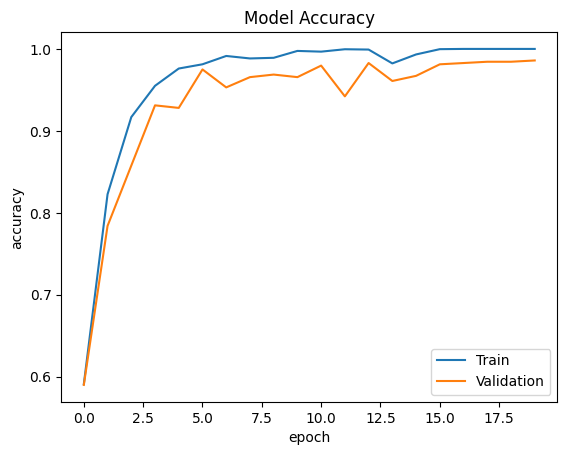

In [40]:
# Model Train & Validation Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training and Validation Accuracy")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

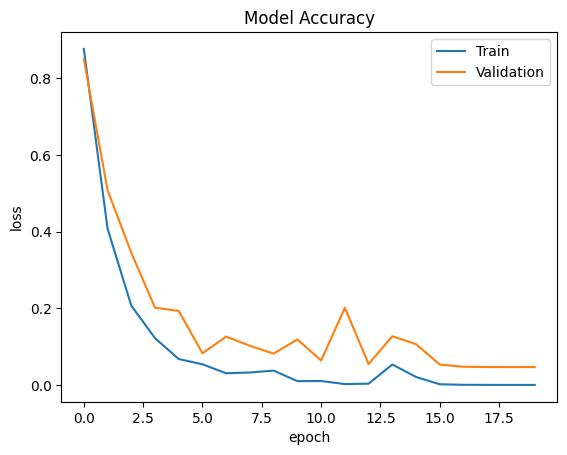

In [41]:
# Model Train & Validation Accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training and Validation Loss")
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## 5.6 Model Evaluation

In [42]:
train_evaluate = model_2.evaluate(train_ds_res)
print("Training Accuracy: {:.2f}%".format(train_evaluate[1]*100))
print("Training Loss: {:.2f}%".format(train_evaluate[0]*100))

320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 5.5791e-05
Training Accuracy: 100.00%
Training Loss: 0.01%


In [43]:
val_evaluate = model_2.evaluate(val_ds)
print("Validation Accuracy: {:.2f}%".format(val_evaluate[1]*100))
print("Validation Loss: {:.2f}%".format(val_evaluate[0]*100))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9812 - loss: 0.0522
Validation Accuracy: 98.59%
Validation Loss: 4.66%


## 5.7 Evaluation on Test Data

Accuracy: 96.88%
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.99      0.92      0.95        91
 Moderate_Demented       1.00      0.71      0.83         7
      Non_Demented       0.98      0.98      0.98       320
Very_Mild_Demented       0.94      0.98      0.96       224

          accuracy                           0.97       642
         macro avg       0.98      0.90      0.93       642
      weighted avg       0.97      0.97      0.97       642



Text(0.5, 23.38159722222222, 'Predicted label')

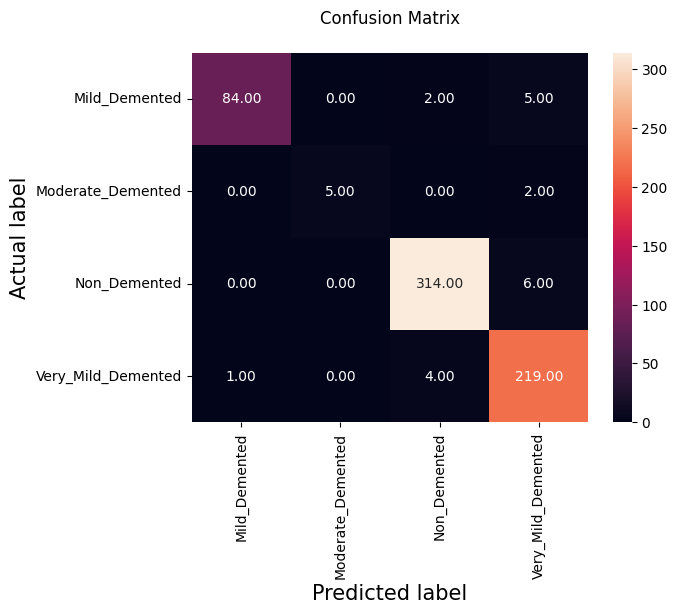

In [44]:
actual = []
predicted= []

for image, label in test_ds.as_numpy_iterator():
    predictions = model_2.predict(image, verbose=0)
    pred = np.argmax(predictions, axis=1)
    predicted.extend(pred)
    actual.extend(label)

actual = np.array(actual)
predicted = np.array(predicted)

print("Accuracy: {:.2f}%".format(metrics.accuracy_score(actual, predicted)*100))
print("Classification Report:\n", metrics.classification_report(actual, predicted, target_names=class_names))
cm = metrics.confusion_matrix(actual, predicted)
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = class_names , yticklabels = class_names)
plt.title('Confusion Matrix\n');
plt.ylabel('Actual label',fontsize=15)
plt.xlabel('Predicted label',fontsize=15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


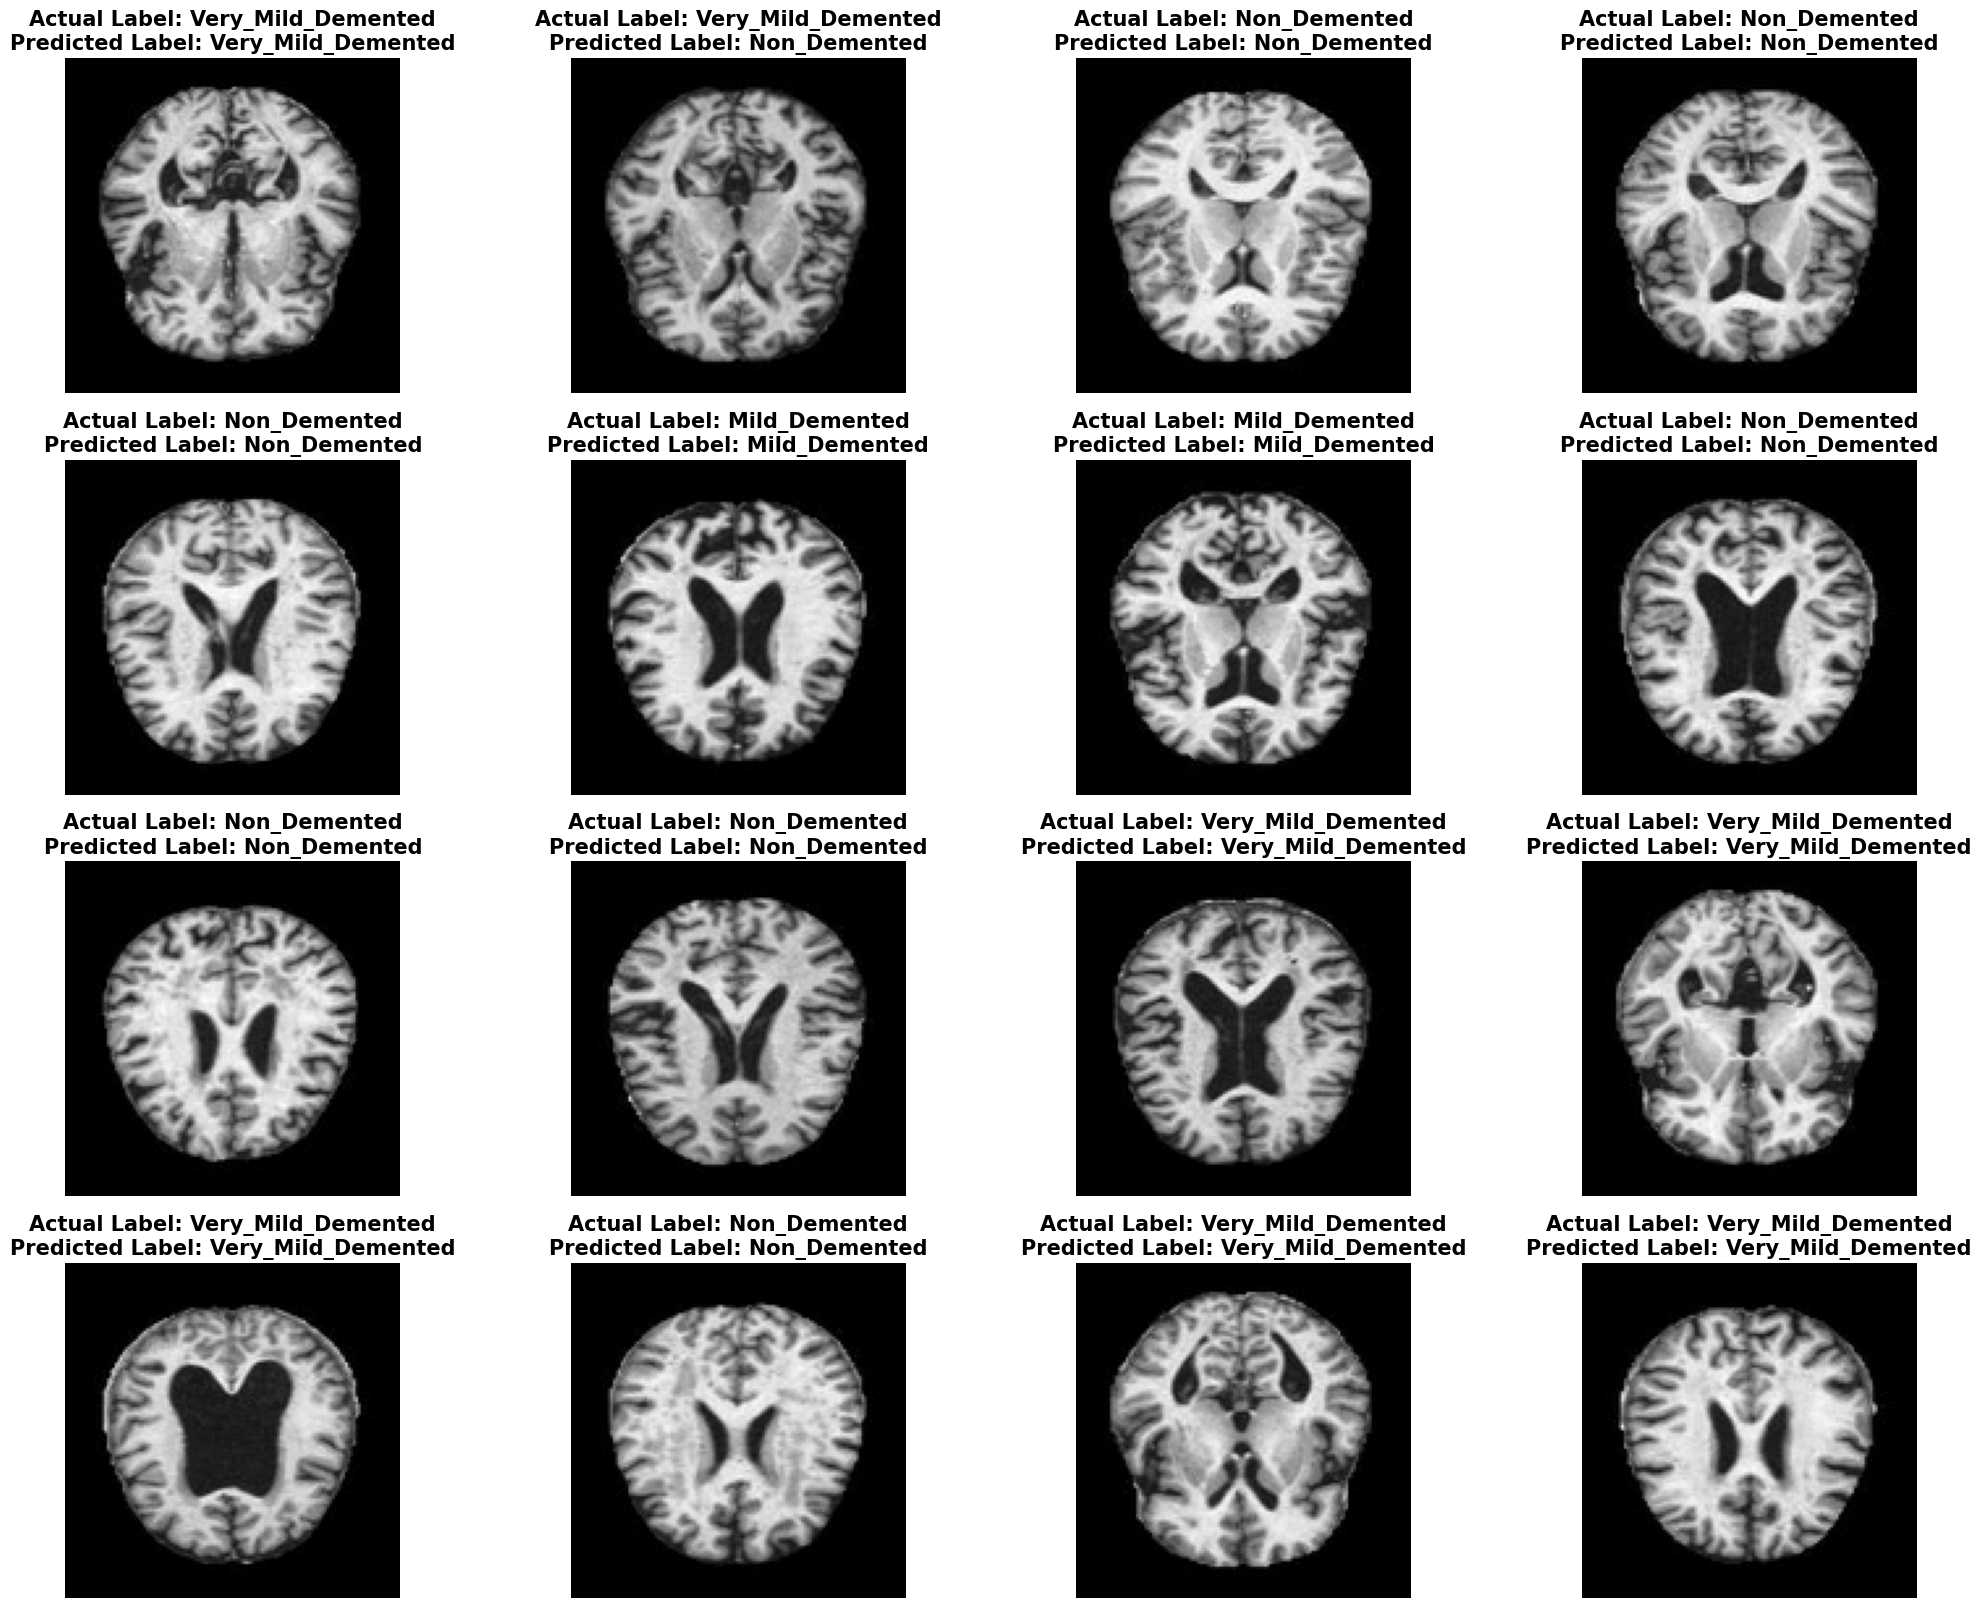

In [45]:
plt.figure(figsize=(25, 20))
for image, label in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model_2.predict(img))
        plt.axis('off')
        plt.title("Actual Label: " + class_names[label[i]] + "\nPredicted Label: " + class_names[predicted_class], fontsize=15, fontweight = 'bold', style='normal', loc='center')
        plt.imshow(image[i].numpy().astype("uint8"))